In [1]:
#Time series generation from generated noise

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class PolymerMotion:
    def __init__(self, num_particles, spring_constants, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.spring_constants = spring_constants
        self.mass = mass if isinstance(mass, np.ndarray) else np.full(num_particles, mass)  # Ensure mass is an array
        self.dt = dt
        self.total_time = total_time
        self.time_steps = int(total_time / dt)

        # Initialize positions and velocities
        self.positions = np.random.rand(num_particles, 2)  # Random initial positions in 2D
        self.velocities = np.zeros((num_particles, 2))  # Start with zero velocity
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))  # To store trajectory

    def forces(self, positions):
        # Calculate the spring forces between particles
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                displacement = positions[j] - positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 0:
                    spring_force = self.spring_constants[i] * displacement / distance
                    F[i] += spring_force
                    F[j] -= spring_force  # Action-reaction pair
        return F

    def motion_equations(self, y, t):
        # Unpack positions and velocities from the state vector y
        positions = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        velocities = y[self.num_particles * 2:].reshape((self.num_particles, 2))

        # Calculate forces
        F = self.forces(positions)

        # Add damping force (assumed uniform damping coefficient)
        damping_coefficient = 0.1  # Adjust this value as needed
        damping_force = -damping_coefficient * velocities

        # Equations of motion: d(position)/dt = velocity, d(velocity)/dt = (force + damping) / mass
        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = velocities.flatten()  # d(position)/dt = velocity
        dydt[self.num_particles * 2:] = ((F + damping_force) / self.mass[:, None]).flatten()  # d(velocity)/dt = (force + damping) / mass

        return dydt

    def simulate(self):
        # Initial state vector: [positions, velocities]
        initial_conditions = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)

        # Integrate the equations of motion using odeint
        solution = odeint(self.motion_equations, initial_conditions, t)

        # Extract positions from the solution and store in trajectory
        self.trajectory = solution[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        return self.trajectory

    def generate_transition_matrix(self):
    # Create a transition matrix based on the entire trajectory
        transition_matrix = np.zeros((self.num_particles, self.num_particles))

    # Calculate cumulative displacement over the trajectory
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))
        for t in range(1, self.time_steps):
            for i in range(self.num_particles):
                for j in range(self.num_particles):
                    displacement = np.linalg.norm(self.trajectory[t, i] - self.trajectory[t - 1, j])

                # Track cumulative displacements for self and inter-particle transitions
                    cumulative_displacements[i, j] += displacement

    # Use cumulative displacement to adjust transition probabilities
        for i in range(self.num_particles):
            row_sum = cumulative_displacements[i].sum()
            if row_sum == 0:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles
            else:
                for j in range(self.num_particles):
                # The smaller the displacement, the higher the transition probability
                    if cumulative_displacements[i, j] > 0:
                        transition_matrix[i, j] = 1 / cumulative_displacements[i, j]

    # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(axis=1)
        for i in range(self.num_particles):
            if row_sums[i] > 0:
                transition_matrix[i] /= row_sums[i]
            else:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles

        return transition_matrix

    def plot_trajectories(self):
        # Plot the trajectories of particles as a function of time
        time = np.linspace(0, self.total_time, self.time_steps)
        plt.figure(figsize=(12, 6))

        for i in range(self.num_particles):
            plt.plot(time, self.trajectory[:, i, 0], label=f'Particle {i+1} X Position', linestyle='-')
            plt.plot(time, self.trajectory[:, i, 1], label=f'Particle {i+1} Y Position', linestyle='--')

        plt.title('Trajectories of Particles Over Time')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.legend()
        plt.grid()
        plt.show()

def generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix):
    # Ensure the correlation matrix is positive definite
    assert np.all(np.linalg.eigvals(target_corr_matrix) > 0), "The correlation matrix must be positive definite."
    
    # Perform Cholesky decomposition on the correlation matrix
    L = np.linalg.cholesky(target_corr_matrix)

    # Generate transition matrix from the polymer model based on trajectory
    transition_matrix = polymer_model.generate_transition_matrix()

    # Generate independent random walks using the transition matrix from the polymer model
    independent_walks = np.zeros((num_walks, num_steps))
    for i in range(num_walks):
        state = np.random.choice(polymer_model.num_particles)  # Random initial state
        walk = [state]
        for _ in range(num_steps - 1):
            state = np.random.choice(polymer_model.num_particles, p=transition_matrix[state])
            walk.append(state)
        independent_walks[i] = np.array(walk)

    # Apply volatilities to scale the independent walks
    scaled_walks = independent_walks 

    # Generate correlated random walks using Cholesky matrix L
    correlated_walks = L @ scaled_walks

    return correlated_walks

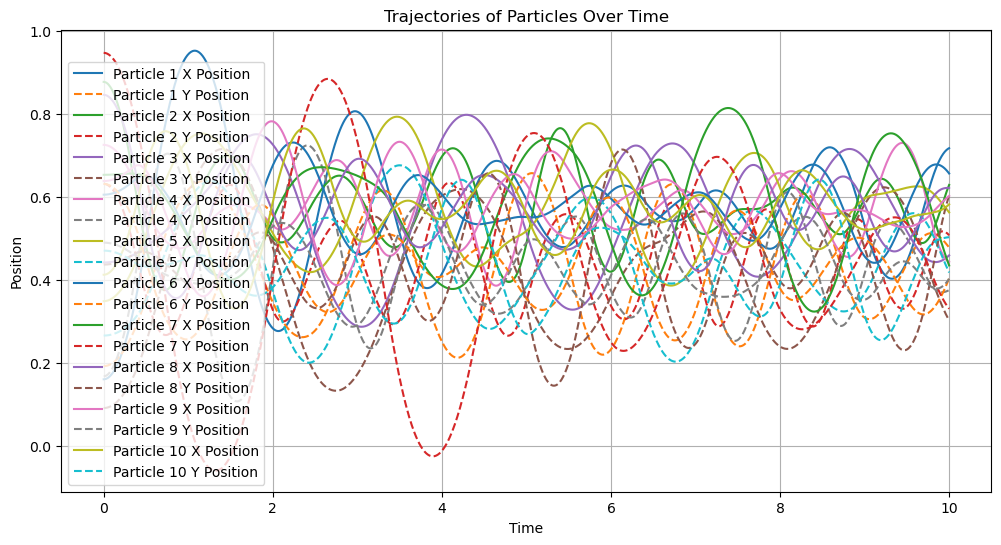

In [45]:
# Parameters
num_particles = 10
spring_constants = np.random.rand(num_particles)  # Random spring constants for each particle
polymer_model = PolymerMotion(num_particles, spring_constants)

# Simulate the polymer motion
trajectory = polymer_model.simulate()

# Plot the trajectories as a function of time
polymer_model.plot_trajectories()

In [46]:
#Generate a correlation matrix from Higham's algorithm

import numpy as np
from scipy.linalg import eigh

# Step 1: Generate a random matrix and symmetrize it
def generate_random_correlation_matrix(n):
    # Generate a random matrix
    A = np.random.rand(n, n)
    
    # Symmetrize the matrix
    A = (A + A.T) / 2
    
    # Step 2: Force diagonal elements to 1 (for correlation matrix)
    np.fill_diagonal(A, 1)
    
    return A

# Step 3: Apply Higham's algorithm to ensure the matrix is PSD
def higham_psd(matrix, tol=1e-8):
    """
    Adjusts the matrix to be positive semi-definite using Higham's algorithm.
    Parameters:
    - matrix: Input matrix to be corrected.
    - tol: Tolerance for eigenvalue correction.
    """
    # Eigen decomposition (guaranteed to work for symmetric matrices)
    eigvals, eigvecs = eigh(matrix)
    
    # Replace negative eigenvalues or those below tolerance with zeros (for PSD)
    eigvals = np.clip(eigvals, tol, None)
    
    # Reconstruct the matrix from modified eigenvalues and eigenvectors
    psd_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
    # Step 4: Rescale to ensure diagonals are exactly 1
    D = np.sqrt(np.diag(psd_matrix))
    psd_matrix = psd_matrix / np.outer(D, D)
    
    # Fix numerical issues with diagonal exactly being 1
    np.fill_diagonal(psd_matrix, 1)
    
    return psd_matrix

# Step 5: Generate a random matrix and make it a PSD correlation matrix
n = 1000  # Number of variables
random_matrix = generate_random_correlation_matrix(n)
psd_matrix = higham_psd(random_matrix)

In [47]:
# Generate and display the transition matrix based on the trajectory
transition_matrix = polymer_model.generate_transition_matrix()
print("Transition Matrix for Correlated Random Walks:")
print(transition_matrix)

# Example of generating correlated random walks
target_corr_matrix = psd_matrix

num_walks = 1000
num_steps = 5000
random_walks = generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix)

Transition Matrix for Correlated Random Walks:
[[0.80494034 0.02197089 0.0201739  0.02074307 0.02483043 0.02096279
  0.01575765 0.02211996 0.02408022 0.02442075]
 [0.02027144 0.77751065 0.02250597 0.02951229 0.02520359 0.02710497
  0.01682186 0.02671221 0.02749834 0.02685868]
 [0.01603024 0.01931862 0.84701492 0.01650671 0.01679486 0.01820716
  0.0106633  0.01772083 0.01959795 0.01814541]
 [0.01929985 0.03008641 0.01944835 0.78938512 0.02267286 0.02376112
  0.01914329 0.02111585 0.02877183 0.02631532]
 [0.01831124 0.01996139 0.01540454 0.01773158 0.84017666 0.01994492
  0.0120457  0.01833438 0.02024177 0.01784783]
 [0.0136538  0.01948633 0.01511444 0.01659544 0.01797054 0.83190098
  0.0121707  0.02259034 0.02559017 0.02492726]
 [0.01692064 0.019778   0.01465545 0.02196634 0.01749137 0.02003004
  0.83285796 0.01782522 0.01942282 0.01905217]
 [0.01914205 0.02537545 0.01932914 0.01951132 0.02188959 0.02988462
  0.014308   0.79882408 0.02664712 0.02508863]
 [0.01544777 0.019083   0.0158409

In [48]:
#Function to rescale the walks

def rescale_to_limits(data, lower_limit, upper_limit):

    min_val = np.min(data)
    max_val = np.max(data)

    # Rescale using min-max normalization
    rescaled_data = (data - min_val) / (max_val - min_val)  # Normalize to [0, 1]
    rescaled_data = rescaled_data * (upper_limit - lower_limit) + lower_limit  # Scale to [lower_limit, upper_limit]
    
    return rescaled_data

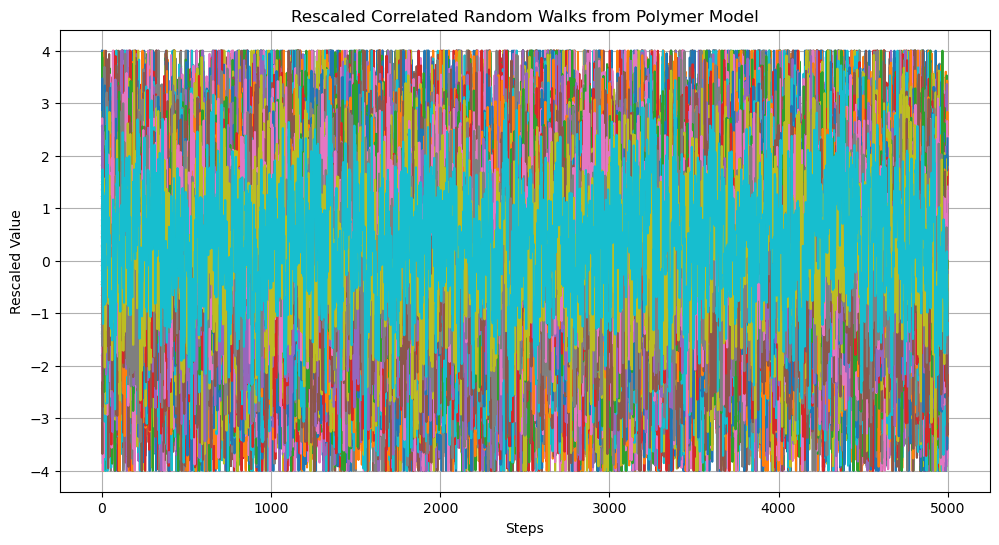

In [49]:
# Rescale each random walk to the range [lower_limit, upper_limit]
lower_limit = -4.0  # Specify the lower limit
upper_limit = 4.0  # Specify the upper limit

plt.figure(figsize=(12, 6))
r=[]

for i in range(random_walks.shape[0]):
    rescaled_walk = rescale_to_limits(random_walks[i], lower_limit, upper_limit)
    r.append(rescaled_walk)
    plt.plot(rescaled_walk, label=f'Walk {i+1}')

plt.title('Rescaled Correlated Random Walks from Polymer Model')
plt.xlabel('Steps')
plt.ylabel('Rescaled Value')
plt.grid()
plt.show()

In [50]:
#Randomly shuffle the generated random walks 

r_shuffled = []

for i in range(len(r)):
    # Make a copy of r[i] to avoid modifying the original array
    temp = r[i].copy()  
    np.random.shuffle(temp)
    r_shuffled.append(temp)

In [51]:
#Time series generator class. We'll use r_shuffled for the noise

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series
        
        for t in range(1, num_steps):
            dW = r_shuffled[t-1][0:num_nodes] * np.sqrt(dt)  #Using rescaled shuffled noise
            correlated_noise = np.dot(self.correlation_decomposition, dW)
            
            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise
            
            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)
            
            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion
            
            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None
    
    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]
    
    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])
            
            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()
            
            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)
            
            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants
    
    return best_params, best_error

In [52]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [53]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.4]
Best error: 0.1430707398859004


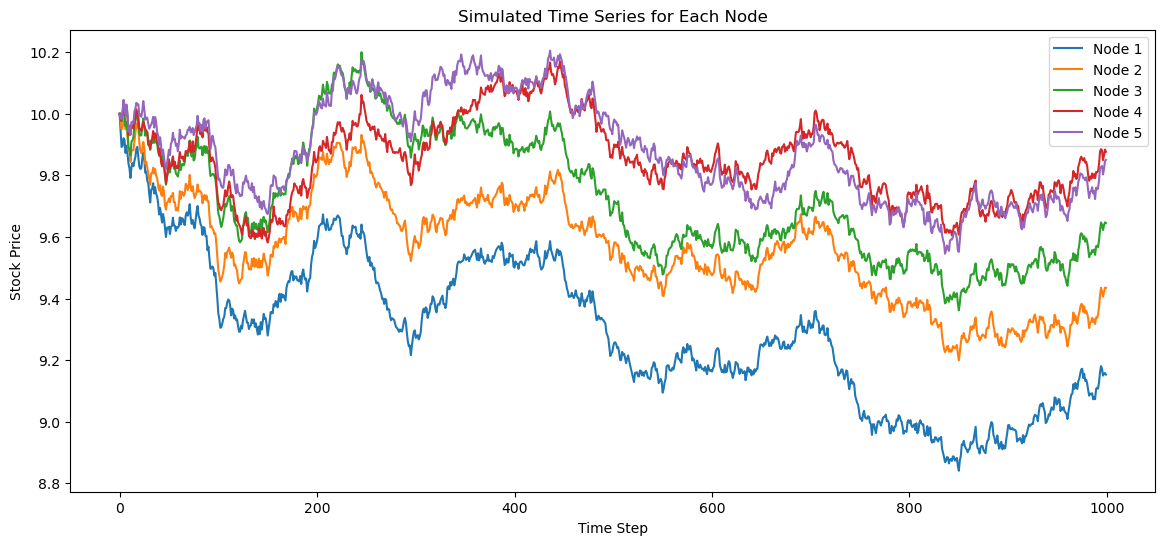

In [54]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

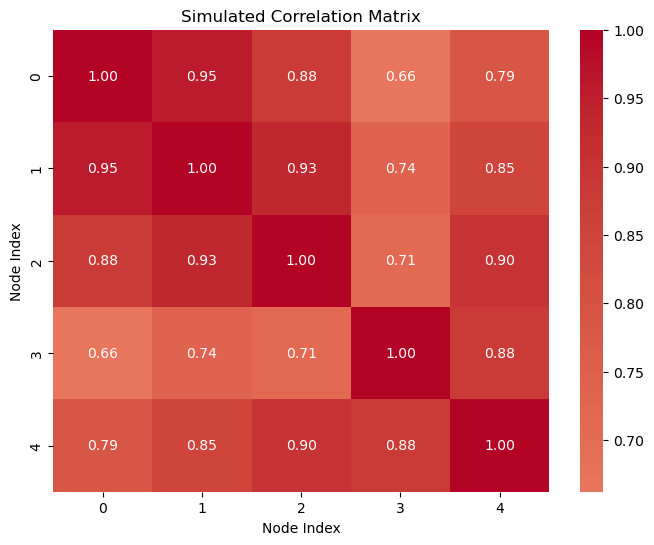

In [55]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()